### The purpose of this notebook is to display the original DPMM scores signals and their post-processed  (shift and Gaussian smoothing) versions.

In [1]:
import os
import json
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# from utils.scoring_utils import dpmm_calc_scores, score_dataset, avg_scores_by_trans
from utils.scoring_utils import score_align

from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import roc_auc_score

### My override score_align

In [2]:
def my_score_align(scores_np, gt, seg_len=12, sigma=40):
    scores_shifted = np.zeros_like(scores_np)
    shift = seg_len + (seg_len // 2) - 1
    scores_shifted[shift:] = scores_np[:-shift]
    scores_smoothed = gaussian_filter1d(scores_shifted, sigma)
    # auc = roc_auc_score(gt, scores_smoothed)
    try:
        auc = roc_auc_score(gt, scores_smoothed)
    except ValueError: # Only one class present in y_true. ROC AUC score is not defined in that case.
        auc = 0
    return auc, shift, sigma, scores_smoothed

### Set Paths

In [3]:
home_dir = '/home/xpct84'
gepc_root_dir = os.path.join(home_dir, 'gepc')
data_dir = os.path.join(gepc_root_dir, 'data')
pose_dir = os.path.join(data_dir, 'pose') 
pose_testing_dir = os.path.join(pose_dir, 'testing')
print(pose_testing_dir)
testing_dir = os.path.join(data_dir, 'testing')
print(testing_dir)

/home/xpct84/gepc/data/pose/testing
/home/xpct84/gepc/data/testing


### Load Ground Truth, Scores, Scores Ids, Metadata 
  
Length of Ground Truth, Scores, and Scores Ids is video length in frames.  
Ground truth is 0 for normal and 1 for abnormal per frame.  
Scores are DPMM (Dirichlet Process Mixture Model) scores per frame.  
Score ids is the person id with max DPMM score (verify).  

Metadata is a (scene_id, clip_id) pai.

In [4]:
data = np.load('mat.npz')
gt_np = data['gt_np']
scores_np = data['scores_np']
score_ids_np = data['score_ids_np']
print(len(gt_np), len(scores_np), len(score_ids_np))
print(gt_np)
print(scores_np)
print(score_ids_np)

40791 40791 40791
[0 0 0 ... 1 1 1]
[48.01218101 48.01264934 46.89920653 ...  0.          0.
  0.        ]
[2 2 1 ... 1 1 1]


In [5]:
# dump(metadata_arr, 'metadata.pkl')
# metadata_arr = pickle.load('metadata.pkl', 'r')
# metadata_arr

with open('metadata.pkl', 'rb') as f:
    metadata_arr = pickle.load(f)
print(metadata_arr)

[[1, 14], [1, 15], [1, 16], [1, 25], [1, 26], [1, 27], [1, 28], [1, 29], [1, 30], [1, 51], [1, 52], [1, 53], [1, 54], [1, 55], [1, 56], [1, 63], [1, 64], [1, 73], [1, 76], [1, 129], [1, 130], [1, 131], [1, 132], [1, 133], [1, 134], [1, 135], [1, 136], [1, 138], [1, 139], [1, 140], [1, 141], [1, 162], [1, 163], [1, 177], [2, 128], [2, 161], [2, 164], [3, 31], [3, 32], [3, 33], [3, 35], [3, 36], [3, 39], [3, 41], [3, 59], [3, 60], [3, 61], [4, 1], [4, 3], [4, 4], [4, 10], [4, 11], [4, 12], [4, 13], [4, 46], [4, 50], [5, 17], [5, 18], [5, 19], [5, 20], [5, 21], [5, 22], [5, 23], [5, 24], [6, 144], [6, 145], [6, 147], [6, 150], [6, 153], [6, 155], [7, 5], [7, 6], [7, 7], [7, 8], [7, 9], [7, 47], [7, 48], [7, 49], [8, 44], [8, 58], [8, 77], [8, 78], [8, 79], [8, 80], [8, 156], [8, 157], [8, 158], [8, 159], [8, 178], [8, 179], [9, 57], [10, 37], [10, 38], [10, 42], [10, 74], [10, 75], [11, 176], [12, 142], [12, 143], [12, 148], [12, 149], [12, 151], [12, 152], [12, 154], [12, 173], [12, 174]

### Original AUC

In [6]:
auc, shift, sigma = score_align(scores_np, gt_np)
# auc, shift, sigma = score_align(scores_np[:265], gt_np[:265])
# auc, shift, sigma = score_align(scores_np[265:], gt_np[265:])
print(auc, shift, sigma)

0.7384495130161979 17 40


### AUC without smoothing

In [7]:
auc = roc_auc_score(gt_np, scores_np)
print(auc)

0.6217428316330164


### AUC after chopping first 50 frames from signal (score an gt)

In [20]:
# gt_np
# scores_np
# # score_ids_np # not relevant
# metadata_arr

filename_num_frames = []
num_frames = np.zeros(len(metadata_arr))
i = 0
for scene_id, video_id in metadata_arr:
    # print(scene_id, video_id)
    # print(f'{scene_id:02}_{video_id:04}.npy')
    
    filename = f'{scene_id:02}_{video_id:04}.npy'
    full_fname = os.path.join(testing_dir, 'test_frame_mask_orig', filename)
    gt = np.load(full_fname)
    _, runs_starts, run_ends = runs_of_ones_array(gt)
    # print(filename, ', #frames =', len(gt), ', any(abnormal) =', any(gt==1), ',', runs_starts, run_ends-1)    
        
    num_frames[i] = len(gt)
    filename_num_frames.append((filename, len(gt)))
    i += 1
    
# num_frames   
# filename_num_frames

sorted(filename_num_frames, key=lambda x:x[1])

[('01_0063.npy', 193),
 ('01_0162.npy', 193),
 ('01_0133.npy', 217),
 ('01_0139.npy', 217),
 ('06_0145.npy', 217),
 ('06_0153.npy', 217),
 ('08_0078.npy', 217),
 ('12_0173.npy', 217),
 ('01_0129.npy', 241),
 ('01_0140.npy', 241),
 ('03_0061.npy', 241),
 ('06_0144.npy', 241),
 ('07_0048.npy', 241),
 ('08_0079.npy', 241),
 ('10_0038.npy', 241),
 ('12_0149.npy', 241),
 ('01_0014.npy', 265),
 ('01_0076.npy', 265),
 ('01_0132.npy', 265),
 ('01_0163.npy', 265),
 ('06_0147.npy', 265),
 ('06_0150.npy', 265),
 ('06_0155.npy', 265),
 ('08_0159.npy', 265),
 ('08_0178.npy', 265),
 ('12_0143.npy', 265),
 ('12_0175.npy', 265),
 ('01_0064.npy', 289),
 ('01_0073.npy', 289),
 ('01_0131.npy', 289),
 ('08_0080.npy', 289),
 ('12_0151.npy', 289),
 ('01_0029.npy', 313),
 ('01_0055.npy', 313),
 ('01_0138.npy', 313),
 ('01_0141.npy', 313),
 ('03_0033.npy', 313),
 ('04_0011.npy', 313),
 ('07_0009.npy', 313),
 ('08_0044.npy', 313),
 ('08_0157.npy', 313),
 ('12_0148.npy', 313),
 ('01_0177.npy', 317),
 ('01_0016.

### AUC as function of sigma

In [9]:
auc_sigma_list = np.zeros(51)
for sigma in range(1, 51):
    auc_sigma_list[sigma], shift, sigma = score_align(scores_np, gt_np, seg_len=12, sigma=sigma)
    print(auc_sigma_list[sigma], shift, sigma)

0.6413804133904871 17 1
0.6508574924710603 17 2
0.6585542337623098 17 3
0.6648760785113753 17 4
0.6703719640700649 17 5
0.675441403822301 17 6
0.6801961884134674 17 7
0.6846581390213796 17 8
0.6887970567495008 17 9
0.6926457453106112 17 10
0.6962362348436406 17 11
0.6996125514165268 17 12
0.7028042150501854 17 13
0.7058149632500768 17 14
0.7086588789958073 17 15
0.7113362660596206 17 16
0.7138838648949948 17 17
0.7162950318676761 17 18
0.7185566543474519 17 19
0.7206813825420099 17 20
0.7226679078939928 17 21
0.7245325873703702 17 22
0.7262716871552232 17 23
0.7278677507982385 17 24
0.7293360456218192 17 25
0.7306761190422177 17 26
0.731897219509931 17 27
0.733011874247933 17 28
0.7340328933440402 17 29
0.7349642098494079 17 30
0.7357884411045513 17 31
0.7365010169974959 17 32
0.7371015882516538 17 33
0.7375757754942578 17 34
0.7379422920793981 17 35
0.7382163856519244 17 36
0.7383962483365395 17 37
0.7384995628754308 17 38
0.7385124885688783 17 39
0.7384495130161979 17 40
0.7382949507

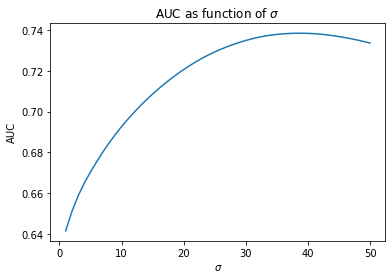

In [10]:
plt.plot(range(1,51), auc_sigma_list[1:])
plt.xlabel('$\sigma$')
plt.ylabel('AUC')
plt.title('AUC as function of $\sigma$')
# plt.savefig('AUCvsSigma.png')
plt.show()

In [10]:
np.argmax(auc_list)

39

In [11]:
full_filenames = sorted(glob.glob(os.path.join(testing_dir, 'test_frame_mask_orig', '*.npy')))
print(full_filenames)

['/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0014.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0015.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0016.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0025.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0026.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0027.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0028.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0029.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0030.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0051.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0052.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0053.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0054.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0055.npy', '/home/xpct84/gepc/data/testing/test_frame_mask_orig/01_0056.

### All ShanghaiTech videos contain Anomaly

### Find length of sequences of identical values in a numpy array (run length encoding)  

https://stackoverflow.com/questions/1066758/find-length-of-sequences-of-identical-values-in-a-numpy-array-run-length-encodi

In [12]:
def runs_of_ones_array(bits):
  # make sure all runs of ones are well-bounded
  bounded = np.hstack(([0], bits, [0]))
  # get 1 at run starts and -1 at run ends
  difs = np.diff(bounded)
  run_starts, = np.where(difs > 0)
  run_ends, = np.where(difs < 0)
  return run_ends - run_starts, run_starts, run_ends

### Loop over metadata filenames, and plot all 107 scores and post-processed scores

In [13]:
for full_fname in full_filenames:
    a = np.load(full_fname)
    _, runs_starts, run_ends = runs_of_ones_array(a)
    print(os.path.basename(full_fname), ', #frames =', len(a), ', any(abnormal) =', any(a==1), ',', runs_starts, run_ends-1)

01_0014.npy , #frames = 265 , any(abnormal) = True , [154] [229]
01_0015.npy , #frames = 433 , any(abnormal) = True , [86] [373]
01_0016.npy , #frames = 337 , any(abnormal) = True , [188] [278]
01_0025.npy , #frames = 601 , any(abnormal) = True , [148] [202]
01_0026.npy , #frames = 505 , any(abnormal) = True , [278] [397]
01_0027.npy , #frames = 409 , any(abnormal) = True , [ 77 150] [148 151]
01_0028.npy , #frames = 457 , any(abnormal) = True , [266 330] [328 330]
01_0029.npy , #frames = 313 , any(abnormal) = True , [133] [245]
01_0030.npy , #frames = 409 , any(abnormal) = True , [149] [348]
01_0051.npy , #frames = 337 , any(abnormal) = True , [ 98 260] [201 325]
01_0052.npy , #frames = 337 , any(abnormal) = True , [119 153] [128 231]
01_0053.npy , #frames = 457 , any(abnormal) = True , [80 86] [ 84 315]
01_0054.npy , #frames = 577 , any(abnormal) = True , [145] [437]
01_0055.npy , #frames = 313 , any(abnormal) = True , [68] [312]
01_0056.npy , #frames = 529 , any(abnormal) = True , [

### Same as above, but using metadata_arr which is more correct.

In [16]:
num_frames = np.zeros(len(metadata_arr), dtype=int)
i = 0
for scene_id, video_id in metadata_arr:
    # print(scene_id, video_id)
    # print(f'{scene_id:02}_{video_id:04}.npy')
    
    filename = f'{scene_id:02}_{video_id:04}.npy'
    full_fname = os.path.join(testing_dir, 'test_frame_mask_orig', filename)
    gt = np.load(full_fname)
    _, runs_starts, run_ends = runs_of_ones_array(gt)
    # print(os.path.basename(full_fname), ', #frames =', len(gt), ', any(abnormal) =', any(gt==1), ',', runs_starts, run_ends-1)    
    print(filename, ', #frames =', len(gt), ', any(abnormal) =', any(gt==1), ',', runs_starts, run_ends-1)    
        
    num_frames[i] = len(gt)
    i += 1

01_0014.npy , #frames = 265 , any(abnormal) = True , [154] [229]
01_0015.npy , #frames = 433 , any(abnormal) = True , [86] [373]
01_0016.npy , #frames = 337 , any(abnormal) = True , [188] [278]
01_0025.npy , #frames = 601 , any(abnormal) = True , [148] [202]
01_0026.npy , #frames = 505 , any(abnormal) = True , [278] [397]
01_0027.npy , #frames = 409 , any(abnormal) = True , [ 77 150] [148 151]
01_0028.npy , #frames = 457 , any(abnormal) = True , [266 330] [328 330]
01_0029.npy , #frames = 313 , any(abnormal) = True , [133] [245]
01_0030.npy , #frames = 409 , any(abnormal) = True , [149] [348]
01_0051.npy , #frames = 337 , any(abnormal) = True , [ 98 260] [201 325]
01_0052.npy , #frames = 337 , any(abnormal) = True , [119 153] [128 231]
01_0053.npy , #frames = 457 , any(abnormal) = True , [80 86] [ 84 315]
01_0054.npy , #frames = 577 , any(abnormal) = True , [145] [437]
01_0055.npy , #frames = 313 , any(abnormal) = True , [68] [312]
01_0056.npy , #frames = 529 , any(abnormal) = True , [

In [ ]:
print(num_frames)

In [17]:
def start_end_frames(num_frames):
    end_frames = np.cumsum(num_frames)
    start_frames = end_frames[:-1]
    start_frames = np.insert(start_frames, 0, 0)    
    return start_frames, end_frames

start_frames, end_frames = start_end_frames(num_frames)
print(start_frames)
print(end_frames)

[    0   265   698  1035  1636  2141  2550  3007  3320  3729  4066  4403
  4860  5437  5750  6279  6472  6761  7050  7315  7556  7893  8182  8447
  8664  9097  9506 10035 10348 10565 10806 11119 11312 11577 11894 12351
 12688 13049 13578 13987 14300 14685 15142 15623 16080 16513 16898 17139
 17692 18629 19494 19999 20312 20673 21034 21563 21900 22333 22814 23463
 24112 24521 24858 25627 26060 26301 26518 26783 27048 27265 27530 27939
 28324 28805 29262 29575 30176 30417 30898 31211 31548 32005 32222 32463
 32752 33089 33402 33739 34004 34269 34606 34967 35400 35641 36074 36675
 37180 37517 38118 38383 38696 38937 39226 39587 39972 40189 40526]
[  265   698  1035  1636  2141  2550  3007  3320  3729  4066  4403  4860
  5437  5750  6279  6472  6761  7050  7315  7556  7893  8182  8447  8664
  9097  9506 10035 10348 10565 10806 11119 11312 11577 11894 12351 12688
 13049 13578 13987 14300 14685 15142 15623 16080 16513 16898 17139 17692
 18629 19494 19999 20312 20673 21034 21563 21900 22333 2

In [18]:
for i in range(len(start_frames)):
    print(gt_np[start_frames[i]:end_frames[i]])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 

In [21]:
for i in range(len(start_frames)):
    print(scores_np[start_frames[i]:end_frames[i]])

[48.01218101 48.01264934 46.89920653 48.01272308 45.77678975 45.1118231
 48.01252643 48.01239414 48.00523161 47.43119686 45.22984437 45.2282598
 45.22865192 45.23025123 45.23013518 45.22909986 46.67277366 45.11121321
 45.11127537 45.1831842  45.13503185 45.11113381 45.11115024 45.11114735
 45.11121491 45.11119297 45.111076   45.15191065 45.1111225  45.22920719
 45.11114403 45.11107961 45.11112895 45.11125397 45.11115348 45.11120207
 48.01274598 48.01250586 48.01241816 48.01235437 48.00875203 41.36370323
 44.76991815 41.3637226  41.36374533 41.36373215 45.20730132 45.22769575
 45.22770394 45.22922634 48.0122188  48.01231187 48.01264631 40.18953274
 48.01229459 48.01221213 48.01220392 48.0122192  48.01219914 48.01227349
 48.01226991 48.01229529 48.01223538 48.01220834 48.01226171 48.01223995
 48.01223803 48.01230973 48.01225111 48.01229747 45.78546591 45.22876845
 45.45641249 45.21575273 47.45592243 48.01221934 48.01226153 46.89965802
 45.22877195 45.22993484 44.35651644 45.11265841 45.1

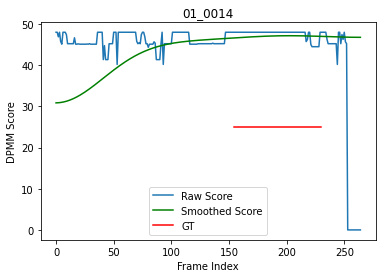

0.9644945697577277


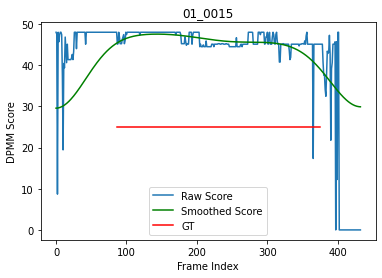

0.9804597701149426


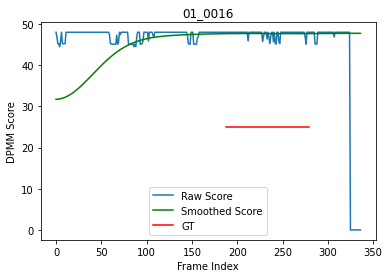

0.8020191190922897


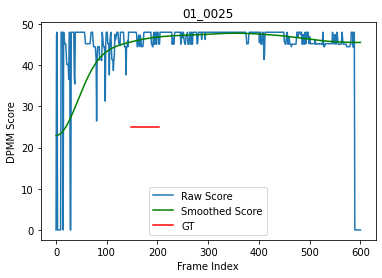

0.45624375624375624


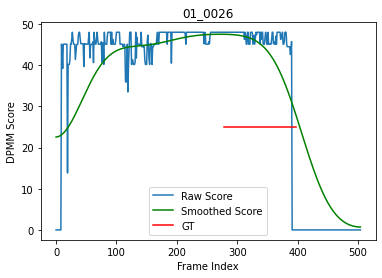

0.6714069264069265


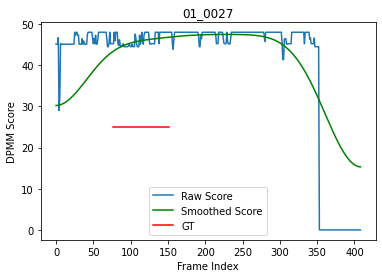

0.5660750302541346


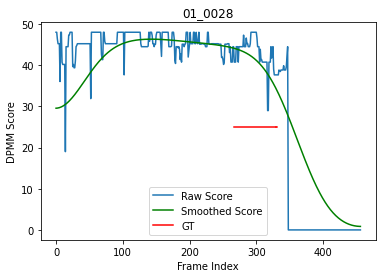

0.49125318066157764


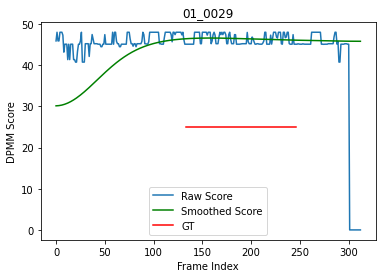

0.9796902654867257


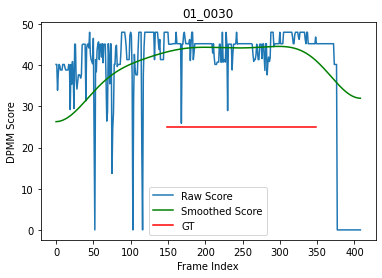

0.9930143540669857


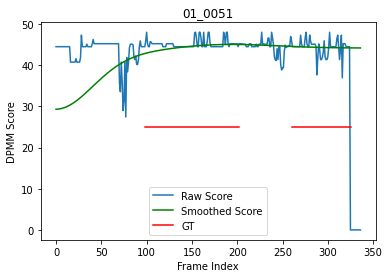

0.7136315604085945


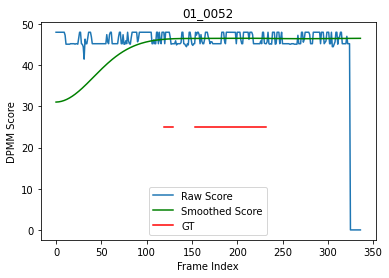

0.900144980065241


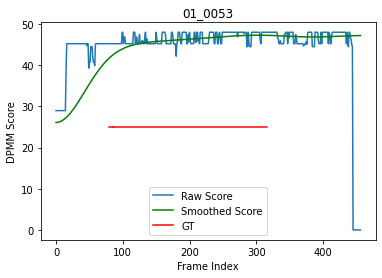

0.5119225608587311


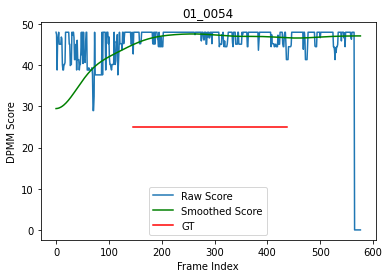

0.8414531557948373


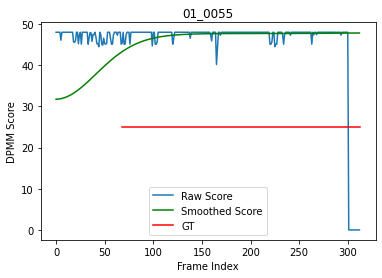

1.0


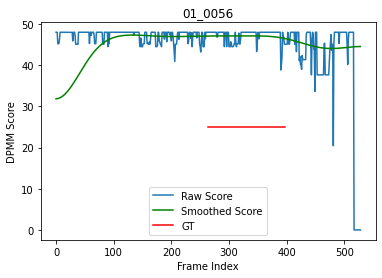

0.7915585636397819


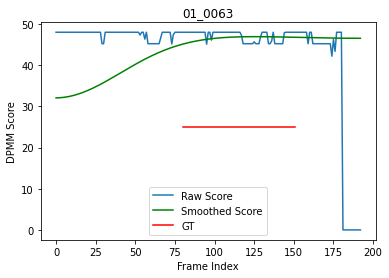

0.8857076887554838


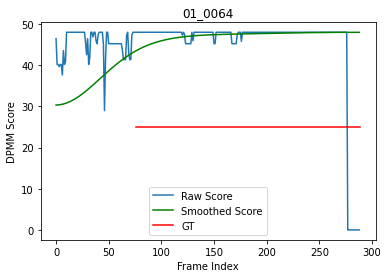

1.0


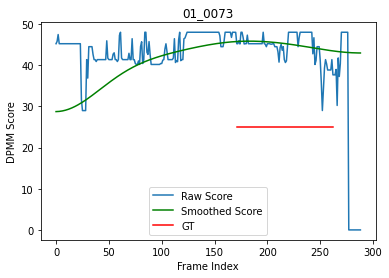

0.8975468975468975


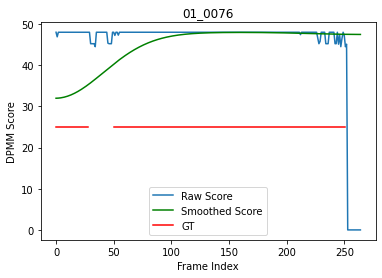

0.7737748665696266


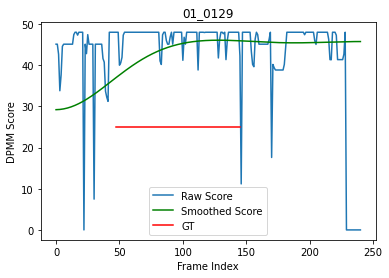

0.5940488083345226


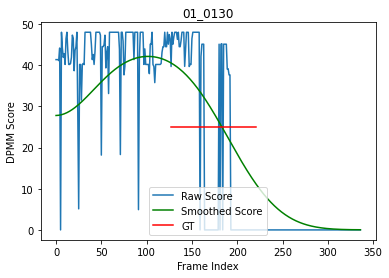

0.5801593555730672


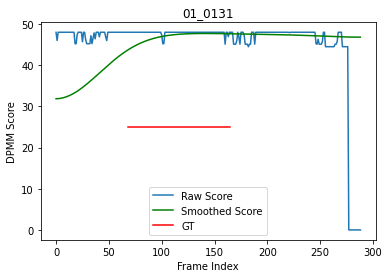

0.7270189003436426


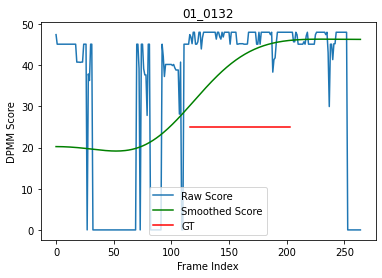

0.651685393258427


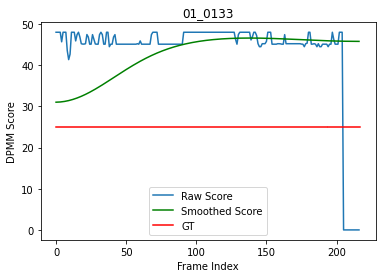

0.4074074074074074


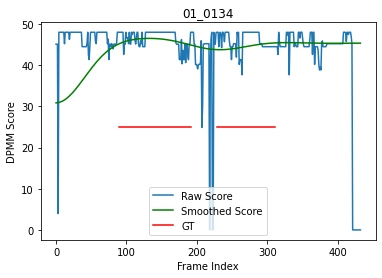

0.7153661726242372


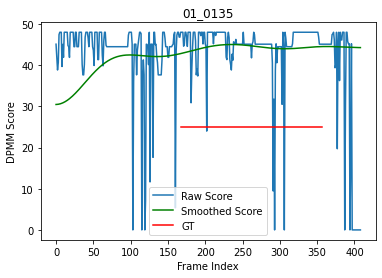

0.8617845117845118


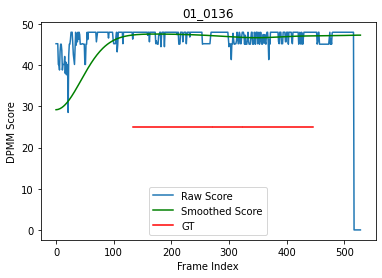

0.7395350895306646


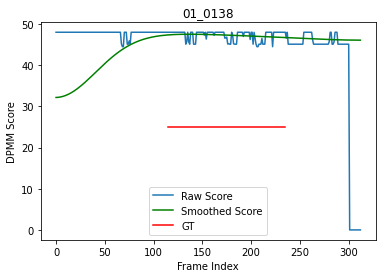

0.971761658031088


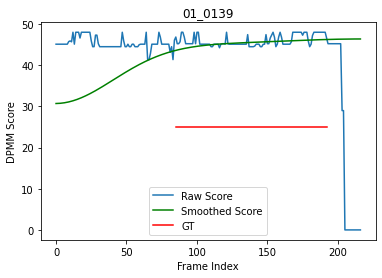

0.7727272727272727


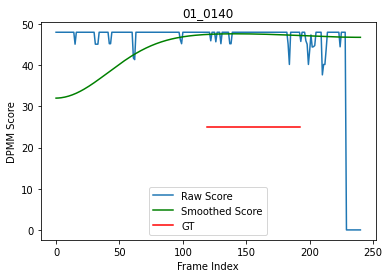

0.9904598825831702


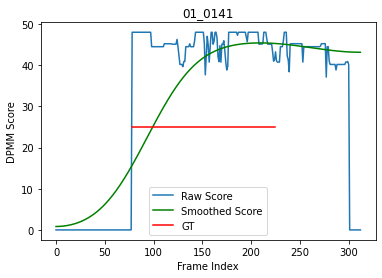

0.654294151423181


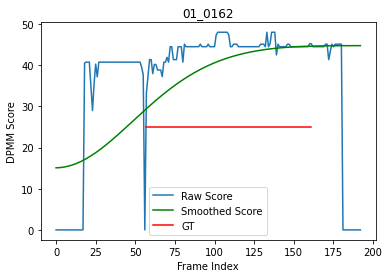

0.6404494382022472


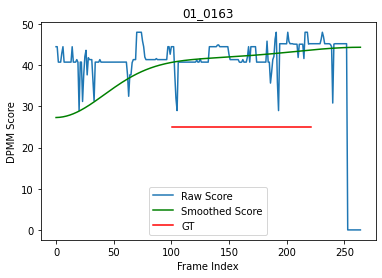

0.6965517241379311


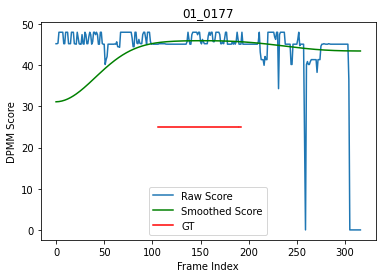

0.9963488843813388


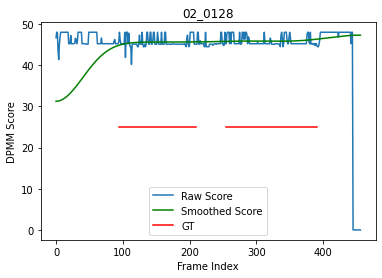

0.5770034843205575


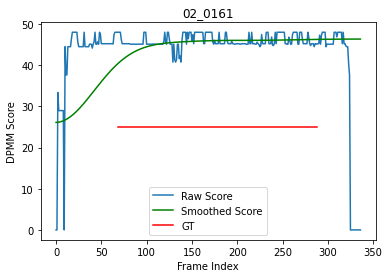

0.5811965811965811


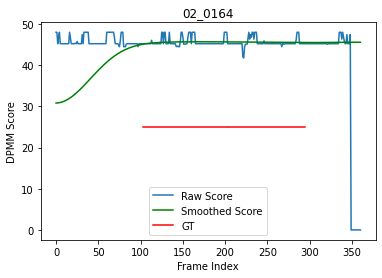

0.8943982763927363


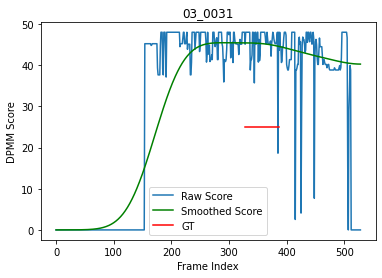

0.8664179104477612


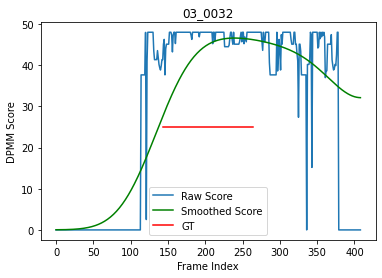

0.8371395617070357


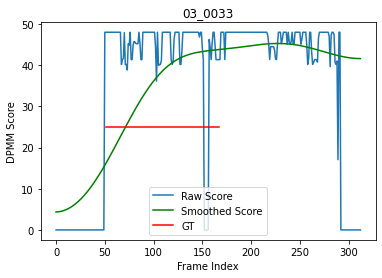

0.31563460693895473


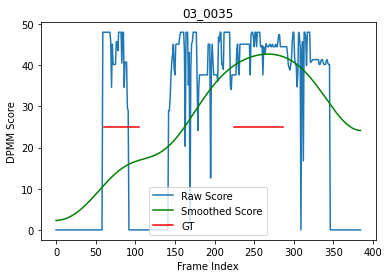

0.6586190572800432


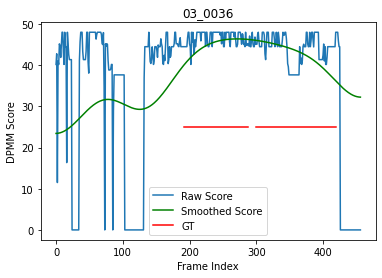

0.9549907791609036


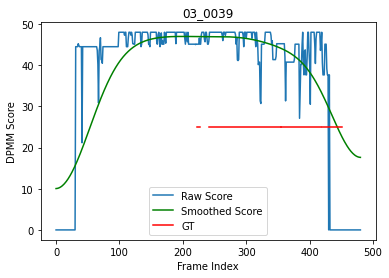

0.5826224328593996


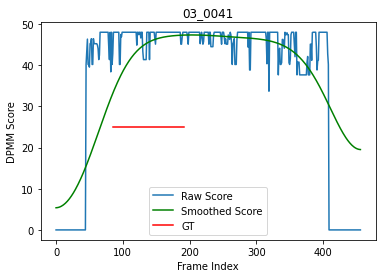

0.6397086491426115


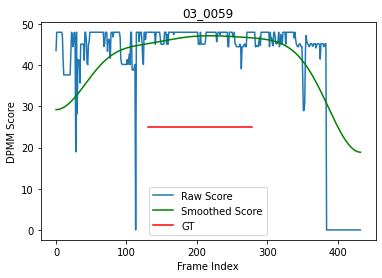

0.9702678274106845


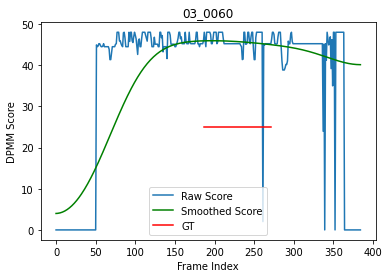

0.9466856510045878


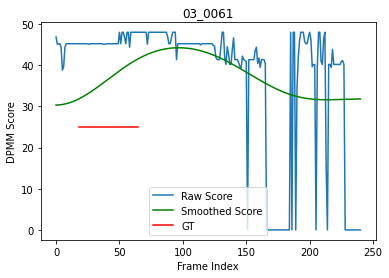

0.5023031366527747


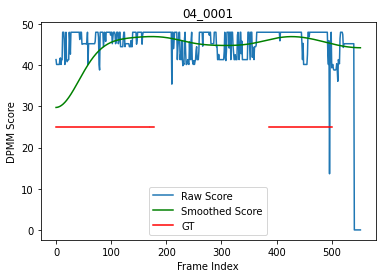

0.5885800445784712


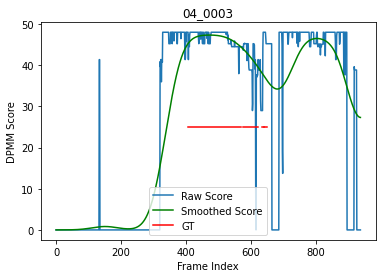

0.915169958801638


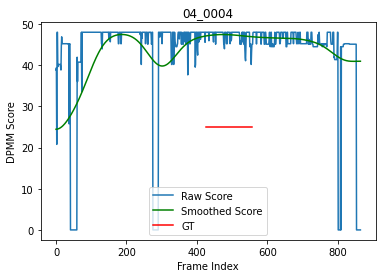

0.9570591313448457


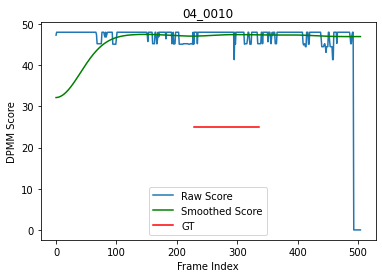

0.754991137232951


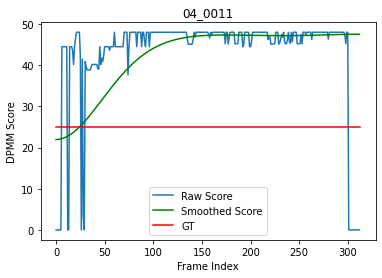

0


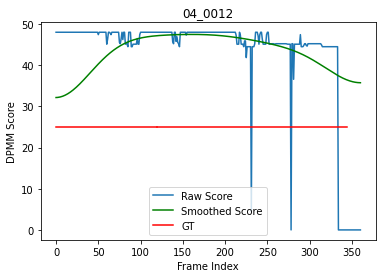

0.8713961775186265


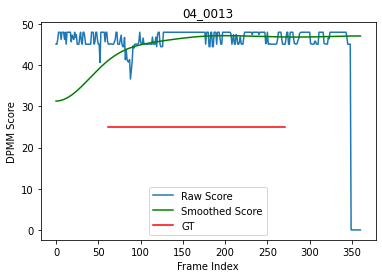

0.6357300536108483


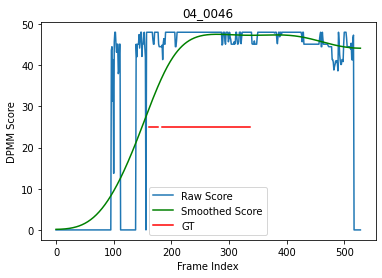

0.7513517941995739


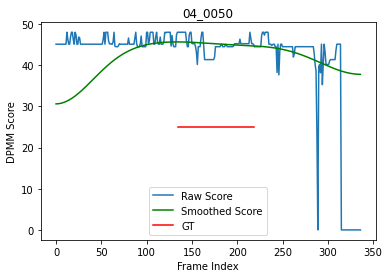

0.8944569922830793


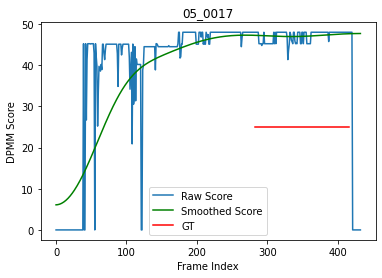

0.8487719298245614


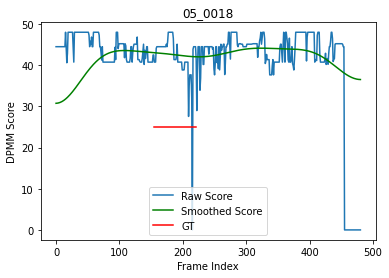

0.43548740416210296


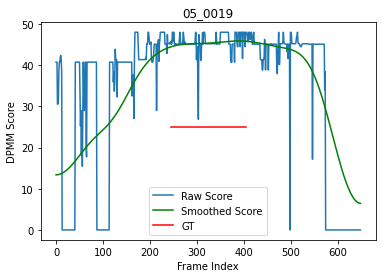

0.9458588957055214


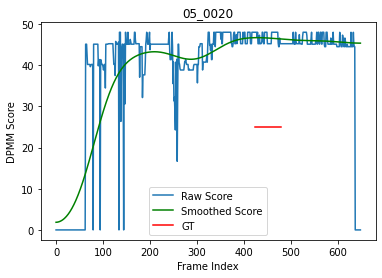

0.9759696458684655


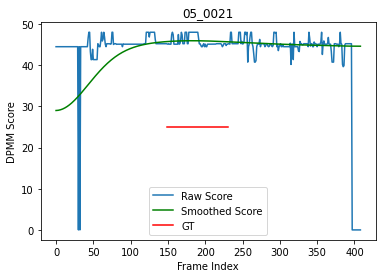

0.999585968081903


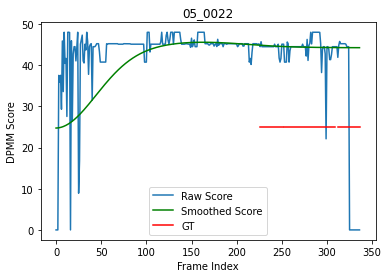

0.5047135310849248


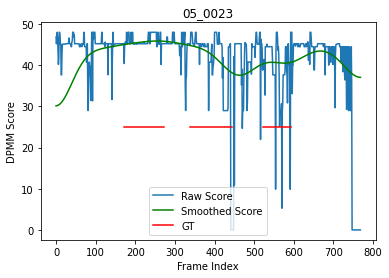

0.6748230743307595


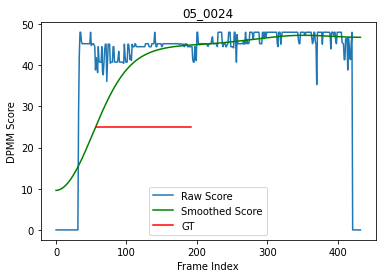

0.1912751677852349


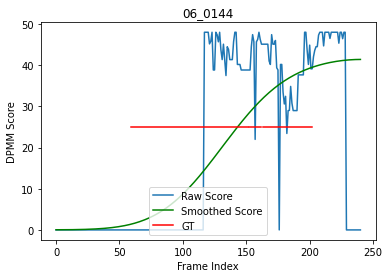

0.5933521923620935


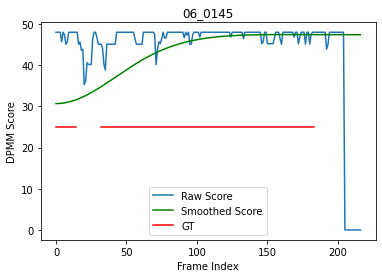

0.453962703962704


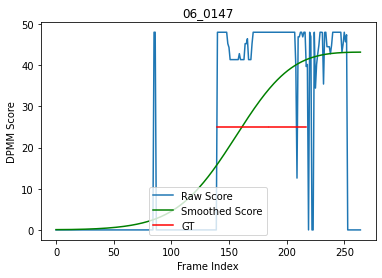

0.7429685324422166


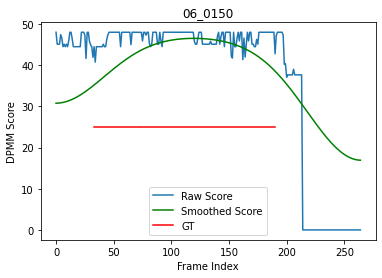

0.9910609268407433


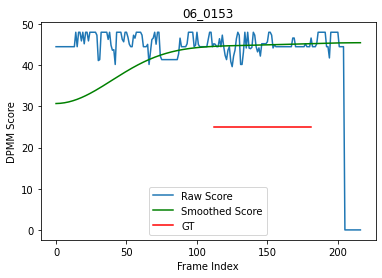

0.7567567567567568


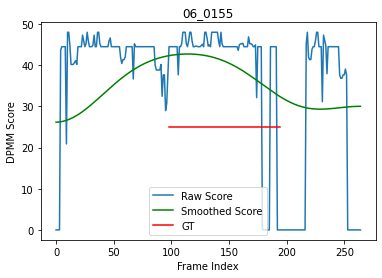

0.8794995069033531


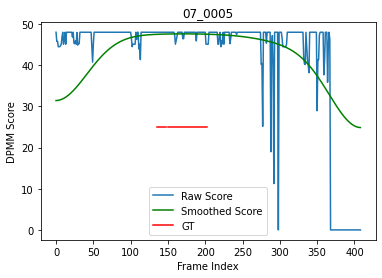

0.9973495891863239


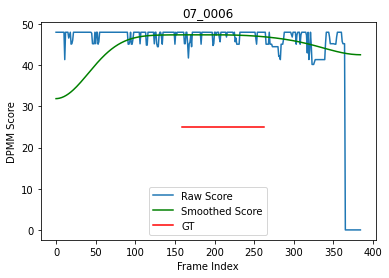

0.9375817668525787


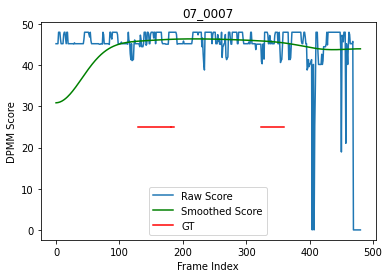

0.6778904777740826


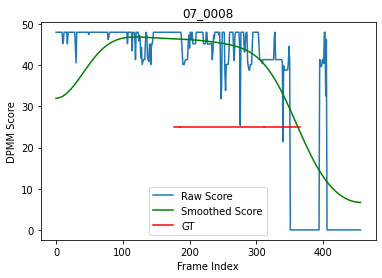

0.5741975161687102


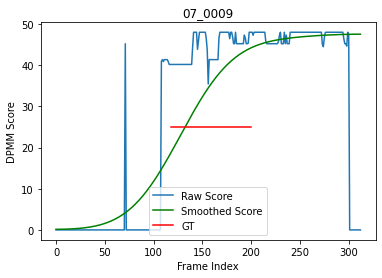

0.5108225108225108


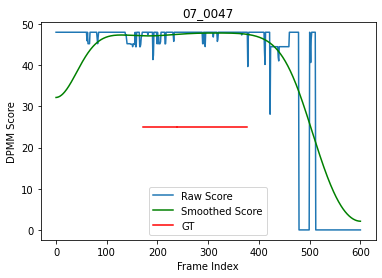

0.9578085642317381


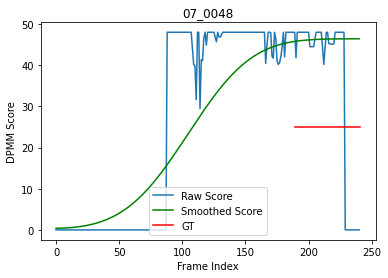

1.0


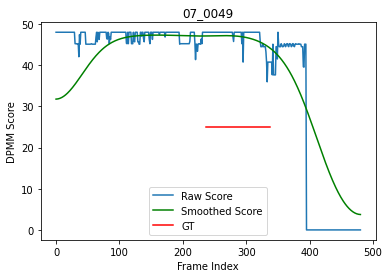

0.7163254593175854


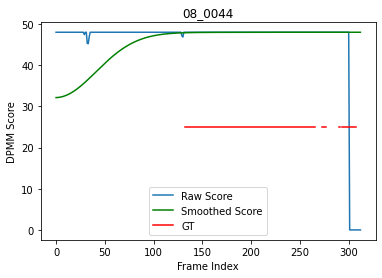

0.8351994115724093


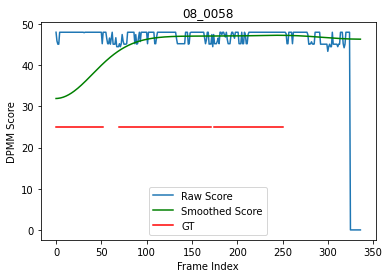

0.5108225108225108


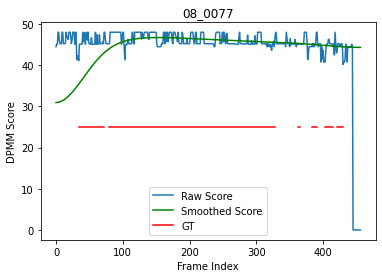

0.8412636861313869


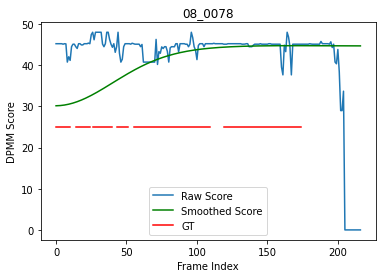

0.3180814770218744


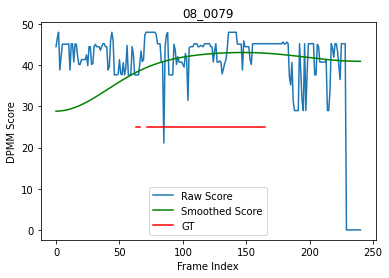

0.826676279740447


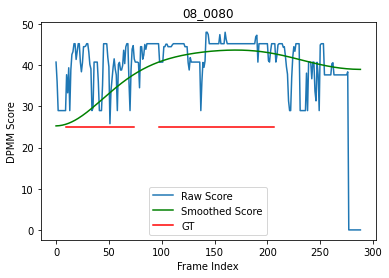

0.6294852573713143


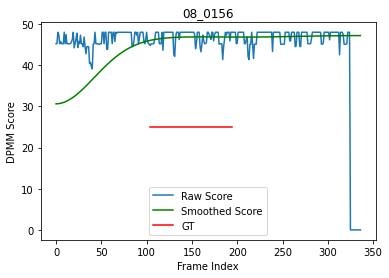

0.5147098515519568


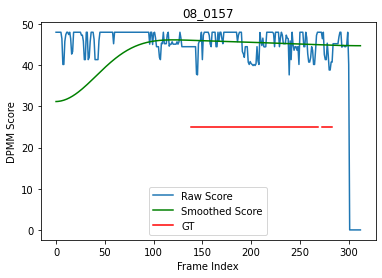

0.7408461157842653


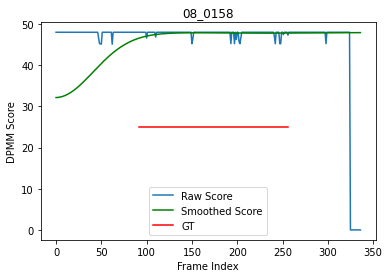

0.5989003242633582


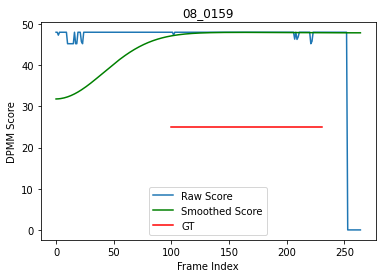

0.9412099806311951


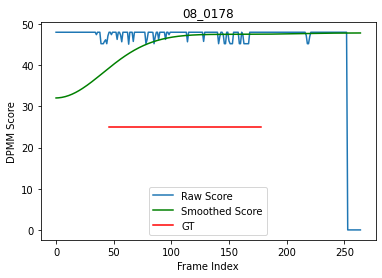

0.3458646616541353


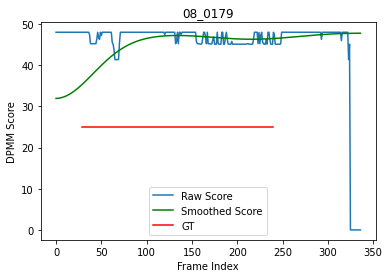

0.322237267734898


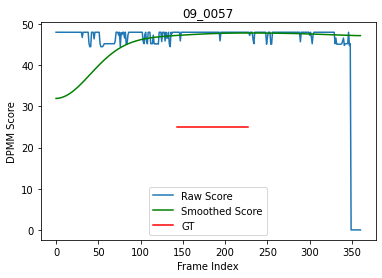

0.7890665291387312


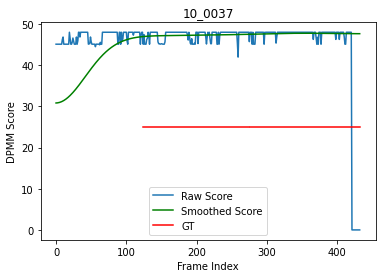

0.9960329888297317


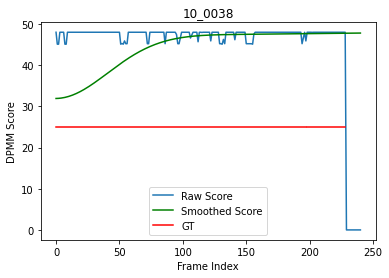

0.009439899307740713


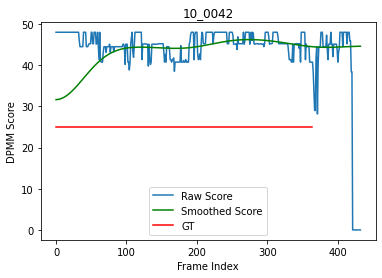

0.465400541487498


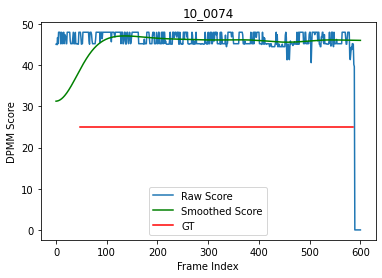

0.9249506254114549


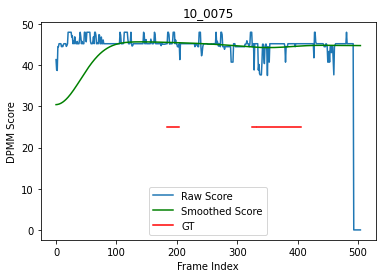

0.34874074074074074


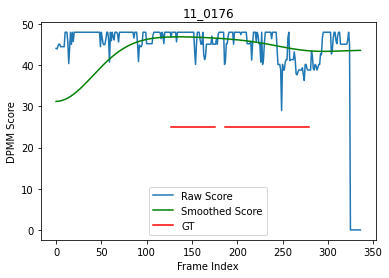

0.8120929222752931


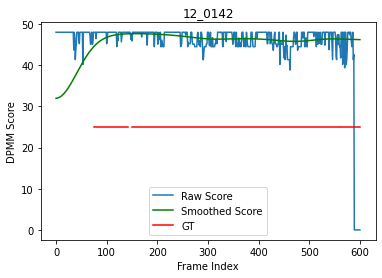

0.9128013534470605


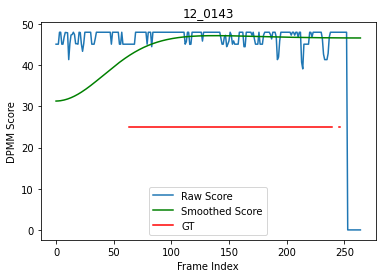

0.9329738058551618


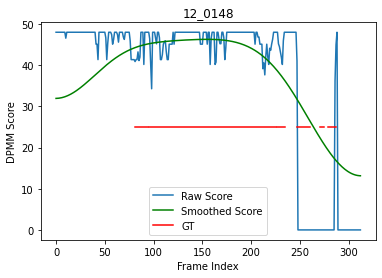

0.8595879029577933


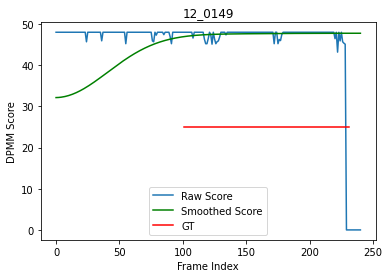

0.9099099099099099


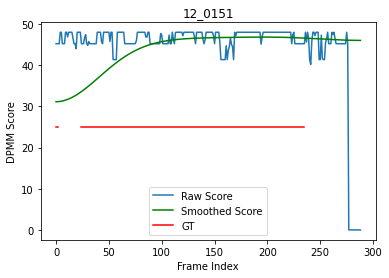

0.6834074623177662


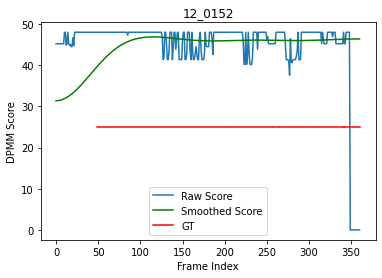

0.9483606557377049


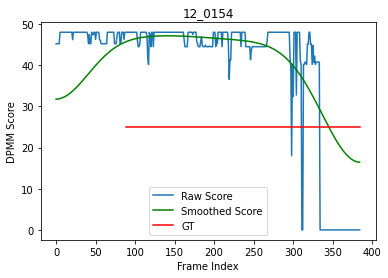

0.7140525356817493


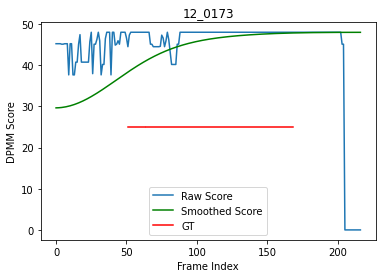

0.5138272447934449


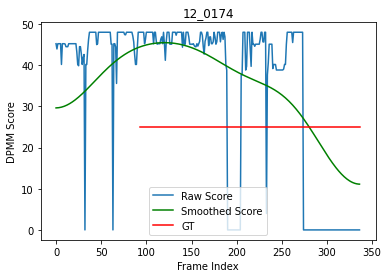

0.49594570773841


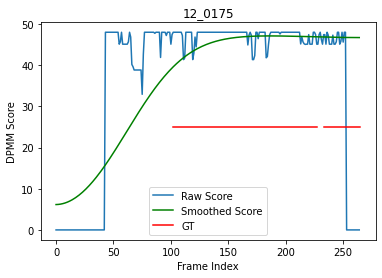

0.9676220806794055


In [27]:
auc_list = np.zeros(len(start_frames))
for i in range(len(start_frames)):
    
    scene_id, video_id = metadata_arr[i]
    filename = f'{scene_id:02}_{video_id:04}'
    
    # plot raw score
    clip_score = scores_np[start_frames[i]:end_frames[i]]    
    plt.plot(np.arange(len(clip_score)), clip_score, label='Raw Score')
    
    # set ground truth
    clip_gt = gt_np[start_frames[i]:end_frames[i]]
    
    # plot smoothed score
    # print(len(clip_score), len(clip_gt))
    auc, shift, sigma, scores_smoothed = my_score_align(clip_score, clip_gt)
    auc_list[i] = auc
    
    plt.plot(np.arange(len(scores_smoothed)), scores_smoothed, 'g', label='Smoothed Score')
    
    # plot ground truth    
    _, runs_starts, run_ends = runs_of_ones_array(clip_gt)
    for j in range(len(runs_starts)):
        if j == 0:
            plt.plot([runs_starts[j], run_ends[j]], [25, 25], 'r', label='GT')
        else:
            plt.plot([runs_starts[j], run_ends[j]], [25, 25], 'r')
        
    plt.legend(loc = 'lower center')
    
    plt.xlabel('Frame Index')
    plt.ylabel('DPMM Score')
    plt.title(filename)
    # plt.savefig(filename + '.png')
    plt.show()
    
    print(auc)

In [26]:
auc_list

array([0.96449457, 0.98045977, 0.80201912, 0.45624376, 0.67140693,
       0.56607503, 0.49125318, 0.97969027, 0.99301435, 0.71363156,
       0.90014498, 0.51192256, 0.84145316, 1.        , 0.79155856,
       0.88570769, 1.        , 0.8975469 , 0.77377487, 0.59404881,
       0.58015936, 0.7270189 , 0.65168539, 0.40740741, 0.71536617,
       0.86178451, 0.73953509, 0.97176166, 0.77272727, 0.99045988,
       0.65429415, 0.64044944, 0.69655172, 0.99634888, 0.57700348,
       0.58119658, 0.89439828, 0.86641791, 0.83713956, 0.31563461,
       0.65861906, 0.95499078, 0.58262243, 0.63970865, 0.97026783,
       0.94668565, 0.50230314, 0.58858004, 0.91516996, 0.95705913,
       0.75499114, 0.        , 0.87139618, 0.63573005, 0.75135179,
       0.89445699, 0.84877193, 0.4354874 , 0.9458589 , 0.97596965,
       0.99958597, 0.50471353, 0.67482307, 0.19127517, 0.59335219,
       0.4539627 , 0.74296853, 0.99106093, 0.75675676, 0.87949951,
       0.99734959, 0.93758177, 0.67789048, 0.57419752, 0.51082

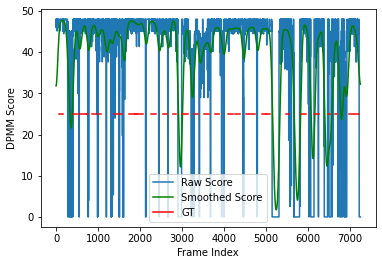

0.7908367600902692


In [31]:
# for i in range(len(start_frames)):
i = 21
num_videos = 20
    
# scene_id, video_id = metadata_arr[i]
# filename = f'{scene_id:02}_{video_id:04}'

# plot raw score
clip_score = scores_np[start_frames[i]:end_frames[i+num_videos]]    
plt.plot(np.arange(len(clip_score)), clip_score, label='Raw Score')

# set ground truth
clip_gt = gt_np[start_frames[i]:end_frames[i+num_videos]]

# plot smoothed score
# print(len(clip_score), len(clip_gt))
auc, shift, sigma, scores_smoothed = my_score_align(clip_score, clip_gt)
# auc_list[i] = auc

plt.plot(np.arange(len(scores_smoothed)), scores_smoothed, 'g', label='Smoothed Score')

# plot ground truth    
_, runs_starts, run_ends = runs_of_ones_array(clip_gt)
for j in range(len(runs_starts)):
    if j == 0:
        plt.plot([runs_starts[j], run_ends[j]], [25, 25], 'r', label='GT')
    else:
        plt.plot([runs_starts[j], run_ends[j]], [25, 25], 'r')

plt.legend(loc = 'lower center')

plt.xlabel('Frame Index')
plt.ylabel('DPMM Score')
# plt.title(filename)
# plt.savefig(filename + '.png')
plt.show()

print(auc)

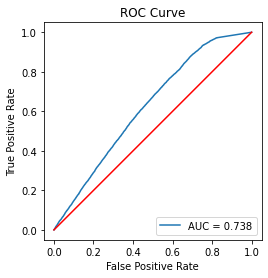

In [20]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(gt_np,  scores_np)

auc, shift, sigma = score_align(scores_np, gt_np)

#create ROC curve
# plt.plot(fpr,tpr,label="AUC="+str(auc))  f"The number is {num:.2f}"
plt.plot(fpr, tpr, label = f"AUC = {auc:.3f}")
plt.plot([0,1],[0, 1], 'r')
plt.axis('square')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve')
# plt.savefig('ROC.png')
plt.show()